In [2]:
import sys
sys.path.append("../Share")
import config, utils, baseline, Trainer, Processing_same_with_MATLAB
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

baseline_K_val = [18] #Train ~18 session data, test with 19~
K = baseline_K_val[0]

feature_names = ['Zero Crossing (ZC)', 'Slope Sign Changes (SSC)', 'Waveform Length (WL)', 'WAMP', 'Mean Absolute Value (MAV)', 'Mean Square (MS)', 'Root Mean Square (RMS)',
                 'v-order 3 (V3)', 'log detector (LD)', 'difference absolute standard deviation value (DASDV)', 'maximum fractal length (MFL)', 'myopulse percentage rate (MPR)',
                 'mean absolute value slope (MAVS)', 'weighted mean absolute (WMS)',
                 'Cepstrum Coefficient 1', 'Cepstrum Coefficient 2', 'Cepstrum Coefficient 3', 'Cepstrum Coefficient Average', 'DWTC1', 'DWTC2',
                 'DWTPC1', 'DWTPC2', 'DWTPC3']


feature_idx = range(0,len(feature_names))

fs = round(10e6 / 2048)  # 4883 Hz
lower_cutoff = 100
upper_cutoff = 600
filter_b, filter_a = Processing_same_with_MATLAB.cheby2(4, 30, [lower_cutoff / (fs/2), upper_cutoff / (fs/2)], btype='bandpass')

feat_mean_1ch = np.array([0.1, 0.1, 2.5, 0.0, 11.0, 229.0, 13.8, -11.0, 9.0, 3.0, 1.5, 0.0, 0.0, 2.8])
feat_std_1ch = np.array([0.02, 0.05, 0.65, 0.02, 4.43, 303.9, 6.85, 12.18, 2.87, 0.87, 0.21, 0.04, 6.68, 1.12])
feat_mean = np.tile(feat_mean_1ch, (4, 1))
feat_std = np.tile(feat_std_1ch, (4, 1))

data_files = config.dataset_sub_H
default_path = config.default_path_sub_H

extractor = Processing_same_with_MATLAB.EMGFeatureExtractor(feat_mean, feat_std, filter_b, filter_a, Norm_bool=False)
X_train_all, y_train_all, X_test_all, y_test_all = [], [], [], []

for idx, session_info in enumerate(data_files):
    print(f"Dataset {idx + 1}/{len(data_files)} - Session {session_info}\n{'='*40}")
    path = os.path.join(default_path, f'{session_info}raw/')
    features, class_labels = [], []
    for c_idx, c in enumerate(config.classes_5):
        raw_data = os.listdir(path+c)
        mat = scipy.io.loadmat(path+c+raw_data[0])
        extractor.buffer = mat['Data_ADC']
        class_labels.append(mat['Data_Cls'].reshape(-1))
        features_per_cls = extractor.extract_features(num_feature_set=23)
        features_per_cls = np.transpose(features_per_cls, (2, 0, 1))  # shape: (1729, 4, 14)
        features.append(features_per_cls)
        #print(features_per_cls.shape, mat['Data_Cls'].reshape(-1).shape)

    X = np.concatenate(features, axis=0)
    y = np.concatenate(class_labels, axis=0)
    if X.shape[0] != y.shape[-1]:
        print(f"Incorrect shape between features and Class: {X.shape} and {y.shape}, {session_info}")
        break

    if idx < K:
        X_train, y_train, _, _,  = utils.split_data(X, y, ratio=1)
        X_train_all.append(X_train)
        y_train_all.append(y_train)

    else:
        X_test, y_test, _, _ = utils.split_data(X, y, ratio=1)
        X_test_all.append(X_test)
        y_test_all.append(y_test)

X_train_stacked = np.concatenate(X_train_all, axis=0)
y_train_stacked = np.concatenate(y_train_all, axis=0)
X_test_stacked = np.concatenate(X_test_all, axis=0)
y_test_stacked = np.concatenate(y_test_all, axis=0)

Dataset 1/50 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/50 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/50 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/50 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/50 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/50 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/50 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/50 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/50 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/50 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 11/50 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/
Dataset 12/50 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/
Dataset 13/50 - Session Exp_2025-06-23-v3/E9AD0E7DCC2B/
Dataset 14/50 - Session Exp_2025-06-23-v4/E9AD0E7DCC2B/
Dataset 15/50 - Session Exp_2025-06-24-v1/E9AD0E7DCC2B/
Dataset 16/50 - Session Exp_2025-06-24-v2/E9AD0E7DCC2B/
Dataset 17/50 - Session Exp_2025-06-24-v3/E9AD0E7DCC2B/
Dataset 18/50 - Session Exp_2025-06-24-v4/E9AD0E7DCC2B/
Dataset

In [6]:
trainer = Trainer.TremorModelTrainer(config, subject="Hunmin")
feature_acc = []

for idx, f in enumerate(feature_idx):
    X_train = X_train_stacked[:, :, f:f+1, :]
    X_test = X_test_stacked[:, :, f:f+1, :]

    X_train = np.squeeze(X_train, axis=-1)  # Remove last dim → (100000, 4, 1)
    X_test = np.squeeze(X_test, axis=-1)

    print(X_train.shape, X_test.shape)

    acc, _ = trainer.train_multiple_dataset(X_train, y_train_stacked, X_test, y_test_stacked)
    feature_acc.append(acc)
    print("\n")

(153388, 4, 1) (274895, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 71.26%
Maximum validation accuracy : 79.57%
Accuracy of test dataset using model V0: 79.5129%


(153388, 4, 1) (274895, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 72.94%
Maximum validation accuracy : 80.79%
Accuracy of test dataset using model V0: 80.6890%


(153388, 4, 1) (274895, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 88.57%
Maximum validation accuracy : 87.58%
Accuracy of test dataset using model V0: 87.3526%


(153388, 4, 1) (274895, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 64.6%
Maximum validation accuracy : 72.41%
Accuracy of test dataset using model V0: 72.4095%


(153388, 4, 1) (274895, 4, 1)
Start Training (total epochs: 50)...
Finish Training! (Model is saved)


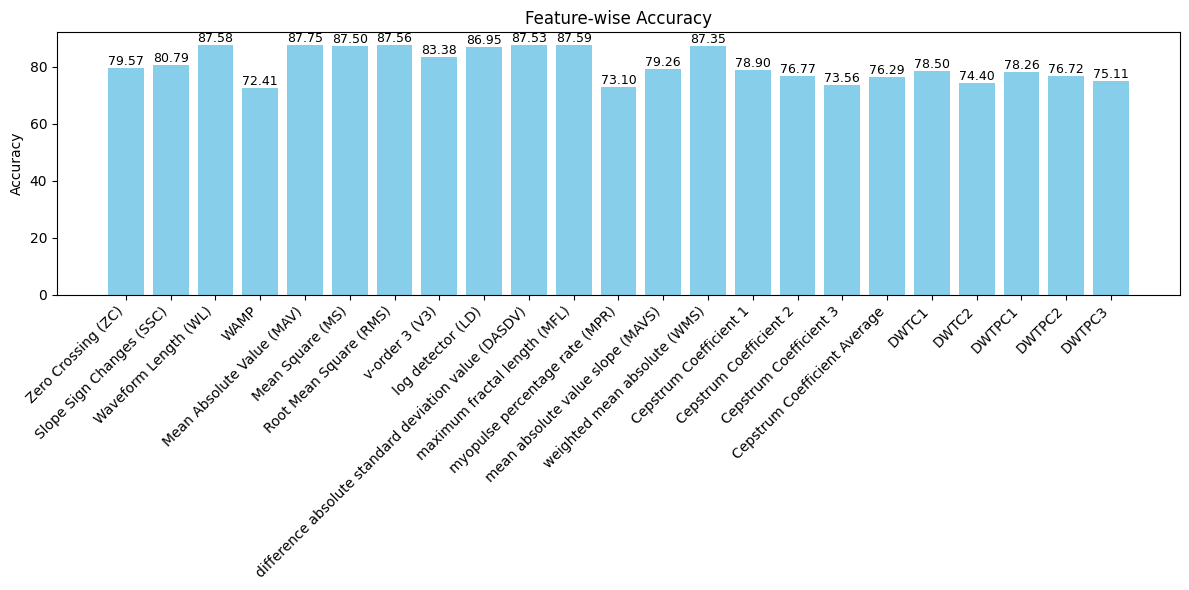

In [13]:
feature_names_idx = feature_names #+ ['All features']

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(feature_acc)), feature_acc, color='skyblue')
plt.xticks(range(len(feature_acc)), feature_names_idx, rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Feature-wise Accuracy')
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)
plt.show()